# Dimensions

<a id="contents"></a>
## Table of Contents

1) [Dimensions vs Job descriptions exploration](#prep)

2) [Feedback Dimensions - Miguel](#feedback)

=======================================================================================================================

<a id="prep"></a>
# 1) Data exploration

In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import re
import spacy
from spacy.matcher import PhraseMatcher
from collections import Counter
import itertools
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
from pathlib import Path

data_folder = str(Path(os.getcwd()).parents[0]) + '\\data\\'

#### Jobs data

In [4]:
%%capture
%run "entities_extraction_DATA.ipynb"

In [5]:
len(jobs_en.body_parsed)

934

In [6]:
# dimensions
dimensions_df = pd.read_excel(data_folder + 'dimensions.xlsx')
dimensions_df.head()

,other_labels,chosen_labels,all_labels
0,Activity-Level,Achievement-Striving,Achievement-Striving
1,ADHD,Adaptability,Adaptability
2,Adventurousness,Ambition/Drive,Ambition/Drive
3,Aesthetic Appreciation/Artistic Interests,Assertiveness,Assertiveness
4,Affective Lability,Competence,Competence


#### Data wrangling

In [7]:
import itertools

# split if /
dimensions_list = [i.split('/') for i in list(dimensions_df['all_labels'])]
dimensions_list[:10]

[['Achievement-Striving'],
 ['Adaptability'],
 ['Ambition', 'Drive'],
 ['Assertiveness'],
 ['Competence'],
 ['Cooperation'],
 ['Creativity', 'Originality'],
 ['Diligence'],
 ['Efficiency'],
 ['Empathy']]

In [8]:
df = pd.DataFrame(list(zip(list(dimensions_df['all_labels']), dimensions_list)), columns=['dimension', 'equivalents'])

# make some replacements
new_equivalents = []
for i in df['equivalents']:
    if len(i) == 1:
        new_equivalents.append([i[0].replace('Interest in ', '').replace('Capacity for ', '').replace(
                                            'Capacity for ', '').replace('Locus of Control,', '').replace(
                                            'Love for ', '').lower()])
    else:
        new_equivalents.append([j.lower() for j in i])

# replace the series
df['equivalents'] = new_equivalents.copy()
print(df.shape)
df.head()

(245, 2)


,dimension,equivalents
0,Achievement-Striving,[achievement-striving]
1,Adaptability,[adaptability]
2,Ambition/Drive,"[ambition, drive]"
3,Assertiveness,[assertiveness]
4,Competence,[competence]


In [9]:
# add stemming (brute force better in this case than lemmatization)

from nltk.stem import LancasterStemmer
lancaster = LancasterStemmer()

# stopwords english
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

new_equivalents_expanded = []
for i in df['equivalents']:
    all_js = []
    for j in i:
        if lancaster.stem(j) != j.lower() and lancaster.stem(j) not in stopwords_en:
            all_js.append([j.lower()] + [lancaster.stem(j.lower())])
        else:
            all_js.append([j.lower()])
    
    # append all
    new_equivalents_expanded.append(list(itertools.chain.from_iterable(all_js)))

# replace the series
df['equivalents'] = new_equivalents_expanded.copy()
print(df.shape)
df.head(10)

(245, 2)


,dimension,equivalents
0,Achievement-Striving,[achievement-striving]
1,Adaptability,"[adaptability, adapt]"
2,Ambition/Drive,"[ambition, ambit, drive, driv]"
3,Assertiveness,"[assertiveness, assert]"
4,Competence,"[competence, compet]"
5,Cooperation,"[cooperation, coop]"
6,Creativity/Originality,"[creativity, cre, originality, origin]"
7,Diligence,"[diligence, dilig]"
8,Efficiency,"[efficiency, efficy]"
9,Empathy,[empathy]


In [10]:
# all equivalents
all_equivalents = list(itertools.chain.from_iterable(list(df['equivalents'])))
all_equivalents[:10]

['achievement-striving',
 'adaptability',
 'adapt',
 'ambition',
 'ambit',
 'drive',
 'driv',
 'assertiveness',
 'assert',
 'competence']

In [11]:
# all words
all_jobs_words = nltk.word_tokenize(' '.join(jobs_en.body_parsed).replace('\n', ''))
all_jobs_words[:10]

['Job', 'description', ',', 'low-code', 'style', ':', 'As', 'the', '#', '1']

In [12]:
# get all original dimensions
dimensions_list_lower = [i.lower() for i in list(itertools.chain.from_iterable(new_equivalents))]
dimensions_list_lower[:10]

['achievement-striving',
 'adaptability',
 'ambition',
 'drive',
 'assertiveness',
 'competence',
 'cooperation',
 'creativity',
 'originality',
 'diligence']

In [13]:
# all words stemmed, with the exception of the original dimensions, in order to avoid duplication
all_jobs_stemmed = [lancaster.stem(i.lower()) for i in all_jobs_words if i.lower() not in dimensions_list_lower]

# add the stems
all_jobs_words_extended = all_jobs_words + all_jobs_stemmed
all_jobs_words_extended[:10]

['Job', 'description', ',', 'low-code', 'style', ':', 'As', 'the', '#', '1']

In [14]:
# words that matter (not counting 2-word all_equivalents)
all_words = [i.lower() for i in all_jobs_words_extended if i.lower() in all_equivalents]
all_words[:10]

['complex',
 'complex',
 'curiosity',
 'drive',
 'complex',
 'security',
 'chance',
 'drink',
 'happy',
 'industry']

#### Two-words cases

In [15]:
# English nlp model
nlp_en = spacy.load('en_core_web_lg')

In [16]:
# two-word dimensions
two_words = []
for i in all_equivalents:
    if len(nlp_en(i)) > 1:
        two_words.append(i)
        
# muitas têm hífen no meio, por isso
hifen_words = []
for i in two_words:
    if '-' in i:
        hifen_words.append(i)
        two_words += [' '.join(i.split('-'))]
        
print(two_words)
print("\n")
print(hifen_words)

['achievement-striving', 'problem-solving', 'risk-taking', 'self-efficacy', 'activity-level', 'aesthetic appreciation', 'artistic interests', 'affective lability', 'appearance-consciousness', 'attention to emotions', 'behavioral inhibition', 'activation system', 'cognitive problems', 'cognitive-failures', 'need for approval', 'mechanical interests', 'cool-headedness', 'emotional detachment', 'emotional stability', 'emotion-based decision-making', 'excitement-seeking', 'fantasy proneness', 'good nature', 'greed avoidance', 'harm-avoidance', 'health anxiety', 'hostile aggression', 'hypomanic exhibitionism', 'hypomanic mood intensity', 'impression-management', 'impulse-control', 'intellectual openness', 'intellectual-breadth', 'intellectual-complexity', 'game-playing', 'home-making', 'outdoor activities', 'political activism', 'self-improvement', 'social media', 'watching television', 'private self-consciousness', 'irrational beliefs', 'open-mindedness', 'language mastery', 'locus of cont

In [17]:
# the same but without hifen
hifen_without_hifen_words = []
for i in hifen_words:
    hifen_without_hifen_words.append(' '.join(i.split('-')))

In [18]:
%%time

# have to split it, because "Text of length 2235737 exceeds maximum of 1000000."
doc1 = nlp_en(' '.join(jobs_en.body_parsed[:300]).replace('\n', ''))
doc2 = nlp_en(' '.join(jobs_en.body_parsed[300:600]).replace('\n', ''))
doc3 = nlp_en(' '.join(jobs_en.body_parsed[600:]).replace('\n', ''))

Wall time: 1min 51s


In [19]:
print(hifen_without_hifen_words[:40])

['achievement striving', 'problem solving', 'risk taking', 'self efficacy', 'activity level', 'appearance consciousness', 'cognitive failures', 'cool headedness', 'emotion based decision making', 'excitement seeking', 'harm avoidance', 'impression management', 'impulse control', 'intellectual breadth', 'intellectual complexity', 'game playing', 'home making', 'self improvement', 'private self consciousness', 'open mindedness', 'negative valence', 'negative valenc', 'non perseverance', 'non planfulness', 'obsessive compulsive symptoms', 'public self consciousness', 'risk avoidance', 'self acceptance', 'self confidence', 'self consciousness', 'self control', 'self regulation', 'self deception', 'self discipline', 'self disclosure', 'self esteem', 'self harm', 'self monitoring', 'self sufficiency', 'social confidence']


In [20]:
%%time

# Phrase Matching
from spacy.matcher import PhraseMatcher

# Initialize the Matcher and add the patterns
matcher = PhraseMatcher(nlp_en.vocab)

# Create pattern Doc objects and add them to the matcher
# This is the faster version of: [nlp_en(country) for country in COUNTRIES]
patterns = list(nlp_en.pipe(two_words))
matcher.add('dimension', None, *patterns)

# Call the matcher on the test document and add to list
two_words_occurrences = []
for doc in [doc1, doc2, doc3]:
    matches = matcher(doc)
    initial_list = [doc[start:end].text for match_id, start, end in matches]
    for i in initial_list:
        if i in hifen_without_hifen_words or i not in hifen_words:
            two_words_occurrences.append(i)

# show list
print(two_words_occurrences)

['problem solving', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'social media', 'social media', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'social media', 'problem solving', 'social media', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'social media', 'social media', 'emotional intelligence', 'social media', 'social media', 'social media', 'social media', 'social media', 'social media', 'social media', 'social media', 'problem solving', 'social media', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'social media', 'problem solving', 'social media', 'problem solving', 'emotional intelligence', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 'social media', 'social media', 'social media', 'problem solving', 'problem solving', 'problem solving', 'problem solving', 

#### Analysis

In [21]:
# count occurrences

count_occurrences = []
for i in df['equivalents']:
    count_here = 0
    for j in i:
        count_here += Counter(all_words)[j]
        count_here += Counter(two_words_occurrences)[' '.join(j.split('-'))]
    count_occurrences.append(count_here)

# add counts
df['count_occurrences'] = count_occurrences.copy()

print(df.shape)
df.head(10)

(245, 3)


,dimension,equivalents,count_occurrences
0,Achievement-Striving,[achievement-striving],0
1,Adaptability,"[adaptability, adapt]",141
2,Ambition/Drive,"[ambition, ambit, drive, driv]",482
3,Assertiveness,"[assertiveness, assert]",4
4,Competence,"[competence, compet]",115
5,Cooperation,"[cooperation, coop]",28
6,Creativity/Originality,"[creativity, cre, originality, origin]",863
7,Diligence,"[diligence, dilig]",13
8,Efficiency,"[efficiency, efficy]",161
9,Empathy,[empathy],19


In [22]:
# check
print(Counter(all_words)['adaptability'])
print(Counter(all_words)['adapt'])

6
135


In [23]:
df.sort_values('count_occurrences', ascending=False)[:20]

,dimension,equivalents,count_occurrences
14,Leadership,"[leadership, lead]",1027
6,Creativity/Originality,"[creativity, cre, originality, origin]",863
192,Responsibility,"[responsibility, respons]",853
148,"Locus of Control,Internal","[internal, intern]",742
114,Interest in Environmentalism,"[environmentalism, environ]",667
219,Social/Personal/Emotional Intelligence,"[social, soc, personal, person, emotional inte...",612
13,Industriousness/Perseverance/Persistence,"[industriousness, industry, perseverance, pers...",580
174,Planfulness,"[planfulness, plan]",577
235,Understanding,"[understanding, understand]",575
158,Morality,"[morality, mor]",520


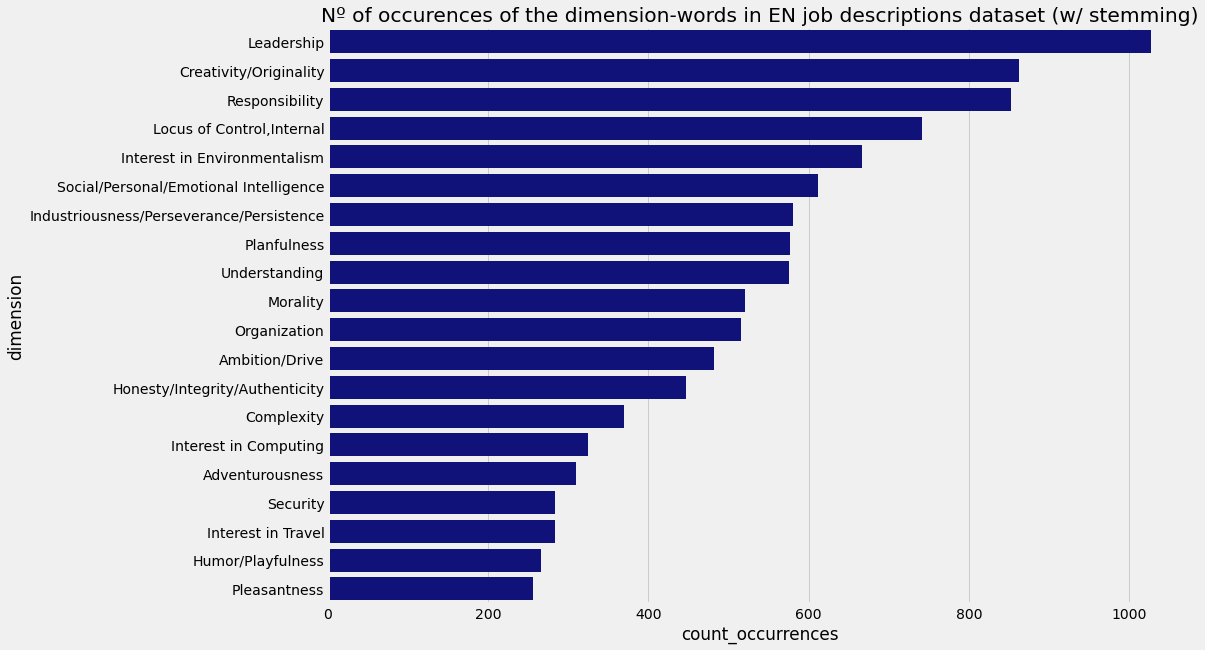

In [24]:
# plot
plt.style.use('fivethirtyeight')
plot_df = df.sort_values('count_occurrences', ascending=False)[:20]

ax = sns.barplot(x='count_occurrences', y='dimension', data=plot_df, color="darkblue")
ax.set_xlabel('count_occurrences')
plt.title('Nº of occurences of the dimension-words in EN job descriptions dataset (w/ stemming)')
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0); plt.show()

Algumas dimensões não têm assim tanto impacto, como 'Responsability', pois o stemming é 'respons', que é igual ao stemming de 'Responsabilities', que é simplesmente o início de muitos parágrafos em cada job description.

In [25]:
lancaster.stem("Responsabilities")

'respons'

In [26]:
# Check "Adventurousness"
adv = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("adventurousness"):
        adv.append(i)   
        
for i in set(adv):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

advisory 9
advice 24
advantageous 10
Advisors 20
advise 14
advantage 56
advancement 6
Advisor 20
Advanced 41
advance 10
advisor 12
advanced 53


### Check how dimensions stems appear on job descriptions text

In [27]:
# Check "Adventurousness"
adv = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("adventurousness"):
        adv.append(i)   
        
for i in set(adv):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

advisory 9
advice 24
advantageous 10
Advisors 20
advise 14
advantage 56
advancement 6
Advisor 20
Advanced 41
advance 10
advisor 12
advanced 53


In [28]:
lancaster.stem("Responsabilities")

'respons'

In [29]:
# Check "Travel"
trav = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("travel"):
        trav.append(i)   
        
for i in set(trav):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

Travel 27
traveling 14
travel 255
travelers 22
travellers 7


In [30]:
# Check "Leadership"
lead = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("leadership"):
        lead.append(i)   
        
for i in set(lead):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

lead 804
Leadership 20
leaders 63
leading 233
Leads 20
Leader 10
leads 42
Lead 113
Leading 13
leader 97
leadership 89


In [31]:
lancaster.stem("leadership")

'lead'

In [32]:
# Check "Computing"
comp = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("computing"):
        comp.append(i)   
        
for i in set(comp):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

computing 21
Computing 6
Computers 6
computer 94
computers 8
Computer 174


In [33]:
# Check "Food"
foodd = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("food"):
        foodd.append(i)   
        
for i in set(foodd):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

food 54
Food 8


In [34]:
# Check "Satisfaction"
satisf = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("satisfaction"):
        satisf.append(i)   
        
for i in set(satisf):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

satisfaction 52


In [35]:
# Check "Security"
secur = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("security"):
        secur.append(i)   
        
for i in set(secur):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

Secure 19
security 154
securing 7
Security 61
secure 31


In [36]:
# Check "creativity"
creat = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("creativity"):
        creat.append(i)   
        
for i in set(creat):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

creating 130
creatively 8
creation 52
Creating 31
creates 11
create 223
Creativity 9
creative 95
created 14
Creative 19
Creation 10
creativity 47
Create 68


In [37]:
# Check "environmentalism"
environm = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("environmentalism"):
        environm.append(i)   
        
for i in set(environm):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

Environment 10
environment 575
environmental 16
environments 53


In [38]:
# Check "planfulness"
planf = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("planfulness"):
        planf.append(i)   
        
for i in set(planf):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

plans 96
planning 131
Plan 53
plan 524
Planning 23
Plans 7
planned 9


In [39]:
# Check "complexity"
complx = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("complexity"):
        complx.append(i)   
        
for i in set(complx):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

complexity 11
complex 354


In [40]:
# Check "humour/playfulness"
hum = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("humour"):
        hum.append(i)   
        
for i in set(hum):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])
        
####

playf = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("playfulness"):
        playf.append(i)   
        
for i in set(playf):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])


player 93
plays 10
Player 8
play 184
players 7


In [41]:
# Check "pleasantness"
pleas = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("pleasantness"):
        pleas.append(i)   
        
for i in set(pleas):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

Please 123
pleasant 6
please 122


In [42]:
# Check "orderliness"
orderl = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("orderliness"):
        orderl.append(i)   
        
for i in set(orderl):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

Order 12
order 156
orders 31


In [55]:
# Check "morality"
moralit = []
for i in all_jobs_words:
    if lancaster.stem(i) == lancaster.stem("morality"):
        moralit.append(i)   
        
for i in set(moralit):
    if Counter(all_jobs_words_extended)[i] > 5:
        print(i, Counter(all_jobs_words_extended)[i])

More 28
more 486
mor 520


## Ver com as dimensões originais apenas

In [43]:
df_origin = pd.DataFrame(list(zip(list(dimensions_df['all_labels']), dimensions_list)), 
                         columns=['dimension', 'dimension_list'])

# make some replacements
new_equivalents = []
for i in df_origin['dimension_list']:
    if len(i) == 1:
        new_equivalents.append([i[0].replace('Interest in ', '').replace('Capacity for ', '').replace(
                                            'Capacity for ', '').replace('Locus of Control,', '').replace(
                                            'Love for ', '').lower()])
    else:
        new_equivalents.append([j.lower() for j in i])

# replace the series
df_origin['dimension_list'] = new_equivalents.copy()
print(df_origin.shape)
df_origin.head(10)

(245, 2)


,dimension,dimension_list
0,Achievement-Striving,[achievement-striving]
1,Adaptability,[adaptability]
2,Ambition/Drive,"[ambition, drive]"
3,Assertiveness,[assertiveness]
4,Competence,[competence]
5,Cooperation,[cooperation]
6,Creativity/Originality,"[creativity, originality]"
7,Diligence,[diligence]
8,Efficiency,[efficiency]
9,Empathy,[empathy]


In [44]:
# # lower
# lower_dimensions = []
# for i in dimensions_list:
#     all_js = []
#     for j in i:
#         all_js.append(j.lower())
#     lower_dimensions.append(all_js)
        
# df_origin=pd.DataFrame(list(zip(list(dimensions_df['all_labels']),lower_dimensions)),columns=['dimension','dimension_list'])
# df_origin.head()

In [45]:
# all words
all_jobs_words2 = [i.lower() for i in nltk.word_tokenize(' '.join(jobs_en.body_parsed).replace('\n', ''))]
all_jobs_words2[:10]

['job', 'description', ',', 'low-code', 'style', ':', 'as', 'the', '#', '1']

In [46]:
# all original dimensions
# dimensions_list_lower = [i.lower() for i in list(itertools.chain.from_iterable(list(df_origin['dimension_list'])))]
# dimensions_list_lower[:10]

In [47]:
# words that matter
all_words2 = [i.lower() for i in all_jobs_words2 if i.lower() in dimensions_list_lower]
all_words2[:10]

['curiosity',
 'drive',
 'security',
 'chance',
 'culture',
 'culture',
 'computing',
 'responsibility',
 'efficiency',
 'social']

In [48]:
# count occurrences

count_occurrences2 = []
for i in df_origin['dimension_list']:
    count_here = 0
    for j in i:
        count_here += Counter(all_words2)[j]
        count_here += Counter(two_words_occurrences)[' '.join(j.split('-'))]
    count_occurrences2.append(count_here)

# add counts
df_origin['count_occurrences'] = count_occurrences2.copy()

print(df_origin.shape)
df_origin.head(10)

(245, 3)


,dimension,dimension_list,count_occurrences
0,Achievement-Striving,[achievement-striving],0
1,Adaptability,[adaptability],6
2,Ambition/Drive,"[ambition, drive]",251
3,Assertiveness,[assertiveness],2
4,Competence,[competence],11
5,Cooperation,[cooperation],17
6,Creativity/Originality,"[creativity, originality]",57
7,Diligence,[diligence],11
8,Efficiency,[efficiency],73
9,Empathy,[empathy],19


In [49]:
df_origin.sort_values('count_occurrences', ascending=False)[:15]

,dimension,dimension_list,count_occurrences
219,Social/Personal/Emotional Intelligence,"[social, personal, emotional intelligence]",322
235,Understanding,[understanding],252
2,Ambition/Drive,"[ambition, drive]",251
148,"Locus of Control,Internal",[internal],244
132,Interest in Travel,[travel],227
203,Security,[security],218
15,Organization,[organization],176
55,Culture,[culture],172
147,"Locus of Control,External",[external],138
192,Responsibility,[responsibility],134


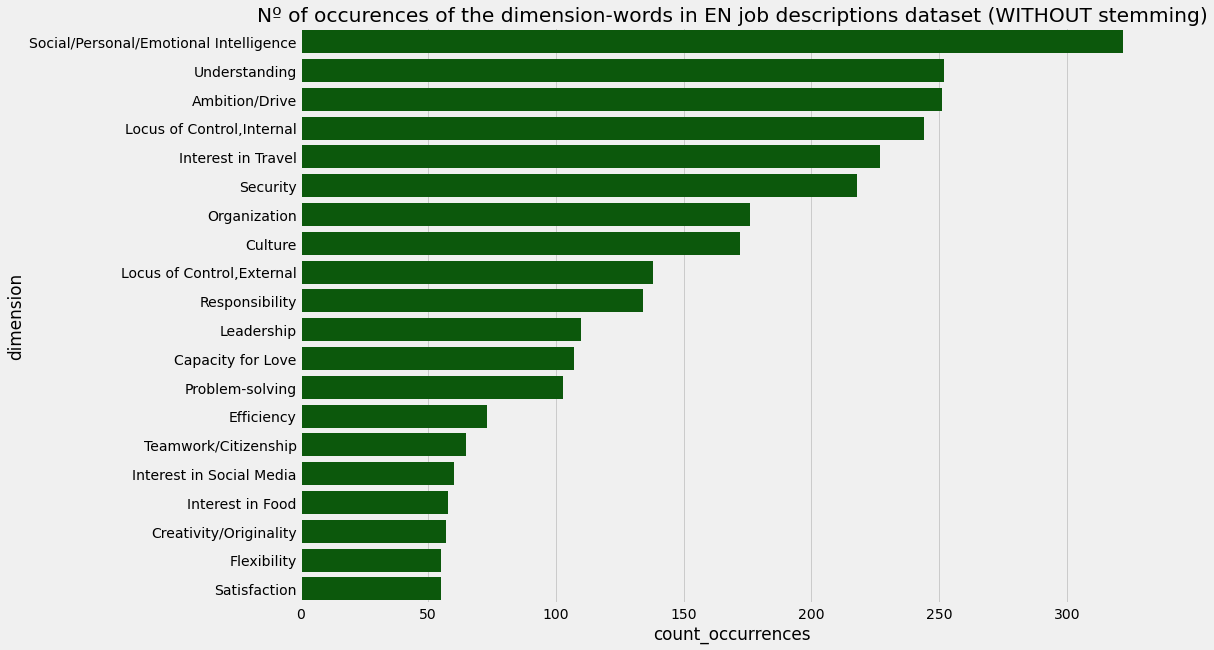

In [50]:
# plot
plt.style.use('fivethirtyeight')
plot_df2 = df_origin.sort_values('count_occurrences', ascending=False)[:20]

ax = sns.barplot(x='count_occurrences', y='dimension', data=plot_df2, color="darkgreen")
ax.set_xlabel('count_occurrences')
plt.title('Nº of occurences of the dimension-words in EN job descriptions dataset (WITHOUT stemming)')
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0)
plt.show()

In [51]:
print(Counter(all_words2)['social'])
print(Counter(all_words2)['personal'])
print(Counter(two_words_occurrences)['emotional intelligence'])

156
162
4


In [52]:
end_time = time.time(); total_time = end_time - start_time
print("""Time to run: {} minutes""".format(round(total_time/60, 1)))

Time to run: 15.2 minutes


=======================================================================================================================

[Table of Contents](#contents)

<a id="feedback"></a>
# Feedback Dimensions - Miguel

### 1) Feedback das 22 dimensões escolhidas

Criei uma coluna no Excel como a Andrea fez (sorry não ponho aqui o link pq isto é público :)

### 2) Dimensões a adicionar - Hipóteses

Proponho olhar para algumas dimensões para vermos se acham relevantes e consistentes com as já escolhidas. 

- **Interest in Travel** (um pouco reticente com os items da escala no entanto)
- **Curiosity**
- **Planfulness** (penso que a MPQ reflete melhor a palavra do que a CPI, aqui, mas é só opinião pessoal)
- **Complexity** (as perguntas em curiosity parecem estar relacionadas)


O que fiz, para já, foi pegar numa amostra de "job descriptions" em Inglês (muitas delas criadas/escritas por empresas portuguesas) e simplesmente contar o número de vezes que cada uma das 245 dimensões listadas aparecem na oferta de emprego, isto é, ver a correspondência direta entre dimensão -> texto na job description. 

Assim, por exemplo, vou contar o número de vezes que as palavras "creativity" + "originality" aparecem (relativamente à dimensão "Creativity/Originality"), ou quantas vezes aparece "leadership" (quanto à dimensão "Leadership").

**20 mais comuns**:

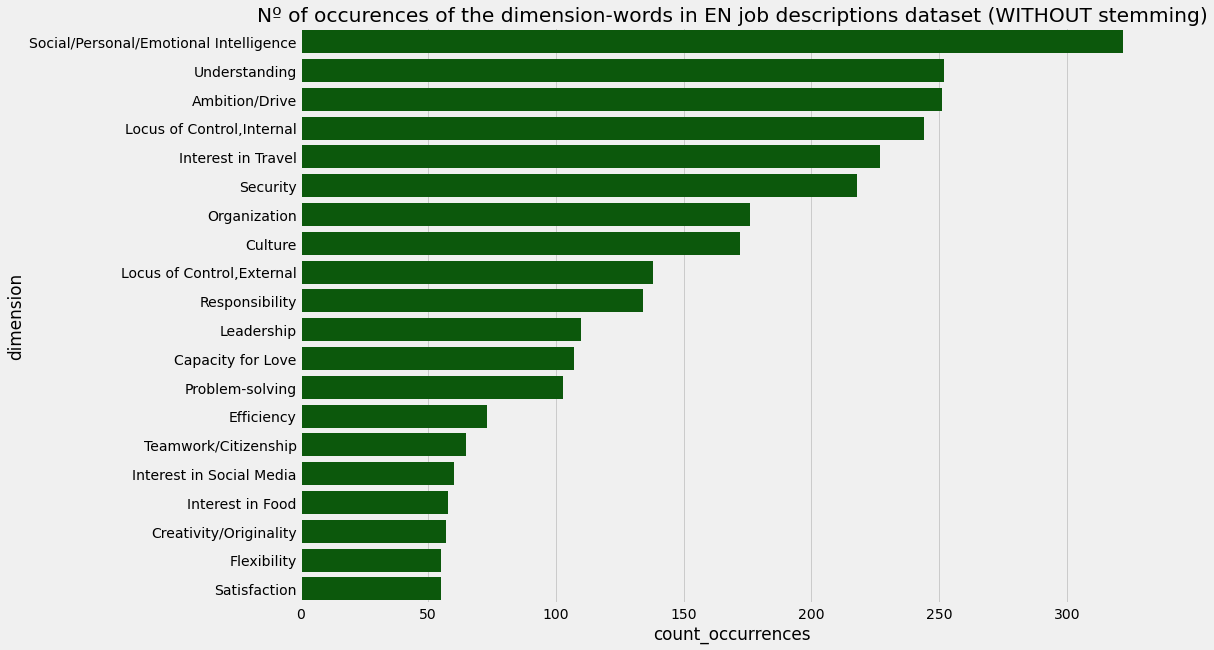

In [53]:
# plot
plt.style.use('fivethirtyeight')
plot_df2 = df_origin.sort_values('count_occurrences', ascending=False)[:20]
ax = sns.barplot(x='count_occurrences', y='dimension', data=plot_df2, color="darkgreen")
ax.set_xlabel('count_occurrences')
plt.title('Nº of occurences of the dimension-words in EN job descriptions dataset (WITHOUT stemming)')
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0)
plt.show()

Alguns exemplos não fazem sentido pensar em incluir nesta lógica, pois medem um aspeto/traço da pessoa diferente do que aquilo a que o texto se refere.

Por exemplo "Culture". Nas escalas perguntam coisas como se vão ao teatro, enquanto que nas job descriptions se referem à cultura da empresa quase sempre.

Outros exemplos na minha opinião: 
- "Understanding"; 
- "Internal" ; 
- "Security" ; 
- "Organization" ; 
- "External" ; 
- "Responsability" ;
- "Love" ; 
- "Social media" ;
- "Food" (perks) ;
- "Satisfaction" (client)


Das que sobram:
    
- Social/Personal/Emotional intelligence --> penso que "Empathy" e "Adaptability" já cobrem isto (?)
- Travel --> é uma das minhas sugestões. Pedido em muitas ofertas

As restantes já estão incluídas nas 22 sugeridas pela Filipa.



### Passo seguinte - ter em conta a raiz das palavras

O que fiz de seguida foi ter em conta a raiz das palavras, usando um processo a que se chama "Stemming" (reduzir palavras flexionadas ao seu tronco (stem), base ou raiz). Isto é, não estava a contar para a dimensão "Creativity/Originality" se no texto aparecesse "creative", por exemplo. Assim, neste caso a raiz de "creativity", "creative", "create", "creating" vai ser sempre igual a "cre".

**20 mais comuns**

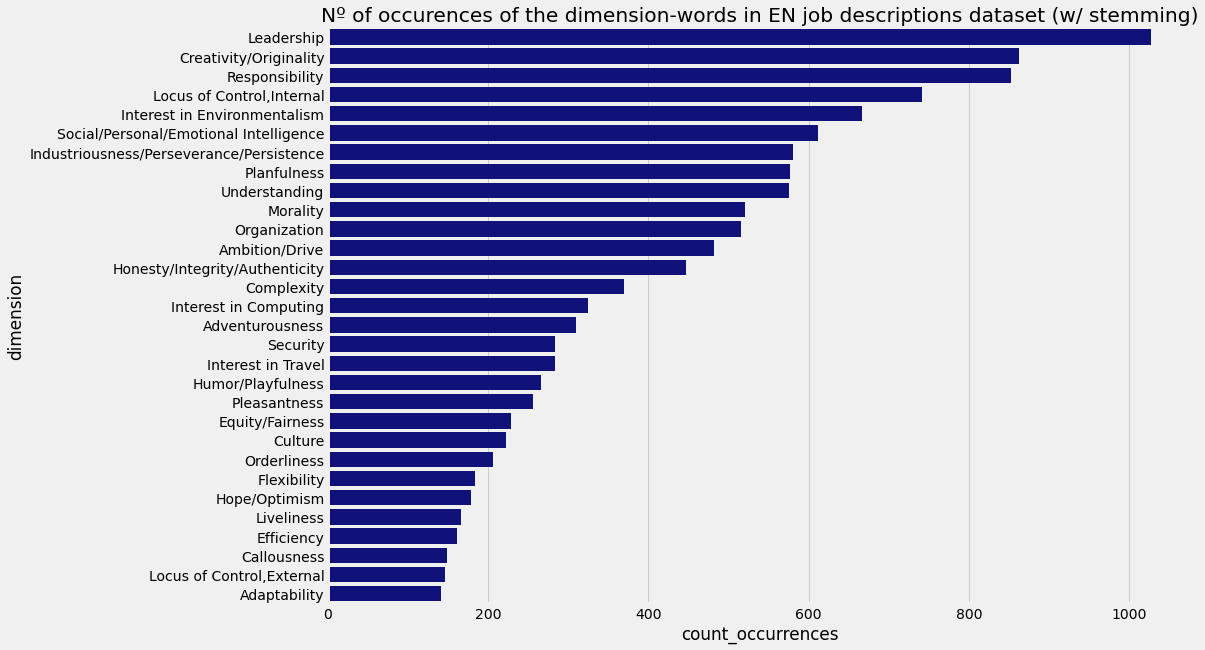

In [54]:
# plot
plt.style.use('fivethirtyeight')
plot_df = df.sort_values('count_occurrences', ascending=False)[:30]

ax = sns.barplot(x='count_occurrences', y='dimension', data=plot_df, color="darkblue")
ax.set_xlabel('count_occurrences')
plt.title('Nº of occurences of the dimension-words in EN job descriptions dataset (w/ stemming)')
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0); plt.show()

Algumas dimensões não têm assim tanto impacto, como 'Adventurousness', pois o stemming é 'adv', que é igual ao stemming de 'advanced', por exemplo.

Outros exemplos ou casos não relevantes na minha opinião: 
- 'Responsability' / 'Responsabilities' (início de muitas job descriptions). Nota: ainda assim parece-me uma dimensão relacionada com o trabalho, mas 'Diligence' cobre bem o termo já.
- 'Internal' / 'internship', 'internal' com outros significados
- 'Environmentalism' / a palavra 'environment' presente nos textos
- 'Understanding'
- 'Organization'
- 'Computing' / palavra computer
- 'Security'
- 'Humour/playfulness' / 'play'
- Pleasantness / tem a ver com 'please'
- Morality -> tem a ver com a palavra "more"


Das que sobram, acrescento à discussão:
    
- Planfulness
- Curiosity
- Complexity 

As restantes já estão presentes na lista da Filipa.